# Parameters and imports

In [1]:
random_seed = 20211205

# Use the "mini" training set with 9 images.
# fcd_ts_dir = '/content/drive/My Drive/PredatorEye/mini_training_set/'
# Use the "real" training set with 2008 images
fcd_ts_dir = '/content/drive/My Drive/PredatorEye/fcd_training_set/'

# max_input_images = 100
max_input_images = 'all'

# Maybe read from image file?
# Maybe assert all images are square and this size?
fcd_image_size = 1024

# Disk diameter, relative to full sized megapixel image.
fcd_disk_size = 201

# For scaling down the input image size.
# input_scale = 1
input_scale = 0.125
# input_scale = 0.25
# input_scale = 0.5
if (input_scale != 1):
    fcd_image_size = int(fcd_image_size * input_scale)
    # does this really want to be an int?
    fcd_disk_size = int(fcd_disk_size * input_scale)

# Enable prototype code for amplifying the FCD dataset using mirror and rotation
# amplification = False
amplification = True

fcd_epochs = 100
fcd_batch_size = 32

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import PIL
import time
import random
import numpy as np
from PIL import Image
from os import listdir
from os.path import join
from tqdm.auto import tqdm
from matplotlib import image
import matplotlib.pyplot as plt

# from DLAVA, includes unused symbols, maybe tighten later
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import Loss

## maybe just write these inline in the code below?
from numpy import asarray 
from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

TensorFlow version: 2.7.0


In [3]:
# Check for Colab Pro resources
def check_colab_resources():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    if ram_gb < 20:
        print('Not using a high-RAM runtime.')
    else:
        print('Using a high-RAM runtime.')
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

check_colab_resources()

Wed Dec 15 00:58:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Utilities

In [4]:
# Prints "expression = <value>"
def debug_print(expression):
    print(expression, '=', eval(expression))

# Reset random sequence seeds in Python's "random", Numpy, and TensorFlow.
def reset_random_seeds():
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

# Parse FCD filename to a list of two ints: (x, y) pixel coordinates.
def fcd_filename_to_xy_ints(filename):
    without_extension = filename.split('.')[0]
    two_numeric_strings = without_extension.split('_')[1:3]
    return list(map(int, two_numeric_strings))

# Get image label from image file names ([x, y] as floats on [0,1])
def fcd_normalized_xy(filename, pixels):
    pixel_coordinates = fcd_filename_to_xy_ints(filename)
    return pixel_coordinates / (np.array(pixels.shape)[1:2] / input_scale)

# Draw a training image on the log. First arg is either a 24 bit RGB pixel
# representation as read from file, or the rescaled 3xfloat used internally.
# Optionally draw crosshairs to show center of disk.
def draw_image(rgb_pixel_tensor, center=(0,0)):
    i24bit = []
    if (rgb_pixel_tensor.dtype == np.double):
        unscaled_pixels = np.interp(rgb_pixel_tensor, [0, 1], [0, 255])
        i24bit = Image.fromarray(unscaled_pixels.astype('uint8'), mode='RGB')
    else:
        i24bit = Image.fromarray(rgb_pixel_tensor)
    plt.imshow(i24bit)
    if (center != (0,0)):
        draw_crosshairs(center)
    plt.show()

# Draw crosshairs to indicate disk position (label or estimate).
def draw_crosshairs(center):
    m = fcd_image_size - 1       # max image coordinate
    s = fcd_disk_size * 1.2 / 2  # gap size (radius)
    h = center[0] * m            # center x in pixels
    v = center[1] * m            # center y in pixels
    plt.hlines(v, 0, max(0, h - s), color="black")
    plt.hlines(v, min(m, h + s), m, color="black")
    plt.vlines(h, 0, max(0, v - s), color="white")
    plt.vlines(h, min(m, v + s), m, color="white")

# Draw line in plot between arbitrary points in plot.
# eg: draw_line((100, 100), (924, 924), color="yellow")
def draw_line(p1, p2, color="white"):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color)

# debug_print('fcd_filename_to_xy_ints("foobar_123_456")')
# debug_print('fcd_normalized_xy("foobar_123_456", np.zeros((1024,1024,3)))')
# debug_print('[123/(1024/input_scale), 456/(1024/input_scale)]')

# Training data reader

In [5]:
# Loads FCD training data image files from "directory_pathname". Returns an
# array of images and an array of labels (each an XY pair, the relative position
# of the disk center). Optional "image_count" can limit the number of images
# read, by taking a random sample of availble image files, defaults to "all".

def read_fcd_data_from_directory(directory_pathname, image_count = 'all'):
    directory_contents = listdir(directory_pathname)
    if (image_count == 'all'): image_count = len(directory_contents)
    assert image_count <= len(directory_contents), "Too few images in directory"
    directory_contents = random.sample(directory_contents, image_count)
    ###
    # 20211210 shouldn't "amp_factor" be a global?
    amp_factor = 1
    if (amplification):
        # amp_factor = 8
        # 20211210 double training set size
        # amp_factor = 3
        amp_factor = 6
        image_count *= amp_factor # for rot/mir
    ###
    # Pre-allocate a tensor for all image data and one for all labels.
    local_images = np.zeros([image_count, fcd_image_size, fcd_image_size, 3])
    local_labels = np.zeros([image_count, 2])
    image_index = 0
    for filename in tqdm(directory_contents):
        image_pathname = join(directory_pathname, filename)
        # Numpy pixel array of image object.
        image = Image.open(image_pathname)
        # pixels = asarray(image.resize((fcd_image_size, fcd_image_size),
        #                               PIL.Image.LANCZOS))
        new_size = (fcd_image_size, fcd_image_size)
        pixels = asarray(image.resize(new_size, PIL.Image.LANCZOS))
        # Convert input image data to floating-point.
        float_pixels = keras_backend.cast_to_floatx(pixels)
        # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
        scaled_pixels = np.interp(float_pixels, [0, 255], [0, 1])
        # Read disk center position from file name.
        center_position = fcd_normalized_xy(filename, pixels)
        def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
        def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])
        if (amplification):
            variations = 8  # 4 from rotations times two from mirroring
            keepers = random.sample(range(1, variations), amp_factor - 1)
            keepers.append(0)
            for i in range(variations):
                if (keepers.count(i) > 0):
                    # Copy pixel data into slice "image_index" of "local_images"
                    local_images[image_index, :, :, :] = scaled_pixels
                    # Copy disk center XY position into slice of "local_labels".
                    local_labels[image_index, :] = center_position
                    image_index += 1
                    draw_frequency = 50 * amp_factor
                    if ((image_index % draw_frequency) == draw_frequency - 1):
                        draw_image(scaled_pixels, center_position)
                        print(image_index + 1, "of", image_count, "images...")
                if (i < 7):
                    if (i == 3):
                        scaled_pixels = np.flip(scaled_pixels, axis=1)
                        center_position = center_flip(center_position)
                    else:
                        scaled_pixels = np.rot90(scaled_pixels, k=1, axes=(0, 1))
                        center_position = center_rot90(center_position)
        else:
            local_images[image_index, :, :, :] = scaled_pixels
            local_labels[image_index, :] = center_position
            image_index += 1
    return local_images, local_labels

# Distance-based loss

In [6]:
# class FCDPositionLoss(Loss):
#     # def __init__(self, regularization_factor=0.1, name="custom_mse"):
#     def __init__(self,
#                  # diameter = fcd_image_size / fcd_disk_size,
#                  diameter = float(fcd_disk_size) / float(fcd_image_size),
#                  name = "custom_mse"):
#         super().__init__(name="fcd_position_loss")
#         self.diameter = diameter

#     def call(self, y_true, y_pred):
#         # mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
#         # reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
#         # return mse + reg * self.regularization_factor
#         # return fcd_position_loss_helper(y_true, y_pred)
#         return corresponding_distances(y_true, y_pred)

class FCDDiskShapedLoss(Loss):
    # def __init__(self, regularization_factor=0.1, name="custom_mse"):
    def __init__(self,
                 # diameter = fcd_image_size / fcd_disk_size,
                #  diameter = float(fcd_disk_size) / float(fcd_image_size),
                 radius = (float(fcd_disk_size) / float(fcd_image_size)) / 2,
                 name = "custom_mse"):
        super().__init__(name="fcd_disk_shaped_loss")
        self.radius = radius

    def call(self, y_true, y_pred):
        # d = corresponding_distances(y_true, y_pred)
        # print("d", d)
        # scaled = (d / self.radius)
        # print("scaled", scaled)
        # exponentiated = scaled ** 4
        # print("exponentiated", exponentiated)
        # return exponentiated
        return fcd_disk_shaped_loss_helper(self.radius, y_true, y_pred)

def fcd_disk_shaped_loss_helper(radius, y_true, y_pred):
    d = corresponding_distances(y_true, y_pred)
    print("d", d)
    # scaled = (d / self.radius)
    scaled = d / radius
    print("scaled", scaled)
    exponentiated = scaled ** 4
    print("exponentiated", exponentiated)
    return exponentiated


# Given two tensors of 2d point coordinates, return a tensor of the Cartesian
# distance between corresponding points in the input tensors.
def corresponding_distances(y_true, y_pred):
    true_pos_x, true_pos_y = tf.split(y_true, num_or_size_splits=2, axis=1)
    pred_pos_x, pred_pos_y = tf.split(y_pred, num_or_size_splits=2, axis=1)
    dx = true_pos_x - pred_pos_x
    dy = true_pos_y - pred_pos_y
    distances = tf.sqrt(tf.square(dx) + tf.square(dy))
    return distances

# def fcd_position_loss_helper(y_true, y_pred):
#     true_pos_x, true_pos_y = tf.split(y_true, num_or_size_splits=2, axis=1)
#     pred_pos_x, pred_pos_y = tf.split(y_pred, num_or_size_splits=2, axis=1)
#     dx = true_pos_x - pred_pos_x
#     dy = true_pos_y - pred_pos_y
#     distances = tf.sqrt(tf.square(dx) + tf.square(dy))
#     return distances

# # 20211209 Test fixtures, keep around for a week or 2 in case I need to debug.
# example_true_positions = tf.convert_to_tensor([[1.0, 2.0],
#                                                [3.0, 4.0],
#                                                [5.0, 6.0],
#                                                [7.0, 8.0]])
# example_pred_positions = tf.convert_to_tensor([[1.1, 2.0],
#                                                [3.0, 4.2],
#                                                [5.0, 6.1],
#                                                [7.3, 8.0]])
# def my_mse(y_true, y_pred):
#     squared_difference = tf.square(y_true - y_pred)
#     # print(squared_difference)
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note `axis=-1`
# debug_print('my_mse(example_true_positions, example_pred_positions)')
# debug_print('fcd_position_loss_helper(example_true_positions, example_pred_positions)')
# debug_print('corresponding_distances(example_true_positions, example_pred_positions)')

In [7]:
# # Prototype metric to measure the fraction of predictions that are inside disks.
# def fcd_prediction_inside_disk(y_true, y_pred):
#     # squared_difference = tf.square(y_true - y_pred)
#     # return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`
#     # loss = fcd_position_loss_helper(y_true, y_pred)
#     distances = corresponding_distances(y_true, y_pred)

#     # radius = (fcd_image_size / fcd_disk_size) / 2
#     relative_disk_radius = (float(fcd_disk_size) / float(fcd_image_size)) / 2

#     # print('radius =', relative_disk_radius)
#     # print('distances =', distances.numpy)

#     # bit = tf.cast(distances + 0.5, tf.int32)
#     # result = tf.cond(x < y, lambda: tf.add(x, z), lambda: tf.square(y))
#     # result = tf.cond(distances < radius, lambda: tf.constant(0), lambda: tf.constant(0))
#     # return result

#     # from https://stackoverflow.com/a/42450565/1991373
#     # y_true = tf.Variable([0.0, 0.3, 0.0, 0.4, 0.0, 0.1, 0.0, 0.0])
#     # comp_op = tf.greater(y_true, 0.1) # returns boolean tensor
#     # cast_op = tf.cast(comp_op, tf.int32) # casts boolean tensor into int32

#     # from https://stackoverflow.com/a/42450565/1991373 -- todo rename variables
#     comp_op = tf.less(distances, relative_disk_radius) # returns boolean tensor
#     cast_op = tf.cast(comp_op, tf.int32) # casts boolean tensor into int32
#     return cast_op


# Prototype metric to measure the fraction of predictions that are inside disks.
# For each pair of 2d points of input, output tensor is 1 for IN and 0 for OUT.
def fcd_prediction_inside_disk(y_true, y_pred):
    distances = corresponding_distances(y_true, y_pred)
    relative_disk_radius = (float(fcd_disk_size) / float(fcd_image_size)) / 2

    # # from https://stackoverflow.com/a/42450565/1991373 -- todo rename variables
    # comp_op = tf.less(distances, relative_disk_radius) # returns boolean tensor
    # cast_op = tf.cast(comp_op, tf.int32) # casts boolean tensor into int32
    # return cast_op

    # From https://stackoverflow.com/a/42450565/1991373
    # Boolean tensor marking where distances are less than relative_disk_radius.
    insides = tf.less(distances, relative_disk_radius)
    map_to_zero_or_one = tf.cast(insides, tf.int32)
    return map_to_zero_or_one


example_true_positions = tf.convert_to_tensor([[1.0, 2.0],
                                               [3.0, 4.0],
                                               [5.0, 6.0],
                                               [7.0, 8.0]])
example_pred_positions = tf.convert_to_tensor([[1.1, 2.0],
                                               [3.0, 4.2],
                                            #    [5.0, 6.1],
                                               [5.0, 6.0],
                                               [7.3, 8.0]])

fcd_prediction_inside_disk(example_true_positions, example_pred_positions)

# lf = FCDDiskShapedLoss()
# lf(example_true_positions, example_pred_positions)


fcd_disk_shaped_loss_helper(0.5 * 201 / 1024,
                            example_true_positions, example_pred_positions)

d tf.Tensor(
[[0.10000002]
 [0.19999981]
 [0.        ]
 [0.3000002 ]], shape=(4, 1), dtype=float32)
scaled tf.Tensor(
[[1.0189058]
 [2.037809 ]
 [0.       ]
 [3.0567183]], shape=(4, 1), dtype=float32)
exponentiated tf.Tensor(
[[ 1.0777948]
 [17.244629 ]
 [ 0.       ]
 [87.3015   ]], shape=(4, 1), dtype=float32)


<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[ 1.0777948],
       [17.244629 ],
       [ 0.       ],
       [87.3015   ]], dtype=float32)>

# Keras model utilities

In [8]:
# Construct a Keras model with CNN layers at the front, striding down in
# resolution, then dense layers funneling down to just two output neurons
# representing the predicted image position center of the conspicuous disk.
# (First version cribbed from DLAVA chapter B3, Listing B3-41)

# def make_striding_cnn_model():
#     cnn_act = 'relu'
#     dense_act = 'relu'
#     output_act = 'linear'
#     cnn_dropout = 0.2
#     # dense_dropout = 0.5  # ala Hinton (2012)
#     model = Sequential()    
#     # 2 CNN layers, 5x5 and 3x3, each striding down to half size. With dropout.
#     model.add(Conv2D(64, (5, 5), activation=cnn_act, padding='same',
#                      strides=(2, 2), kernel_constraint=MaxNorm(3),
#                      input_shape=(fcd_image_size, fcd_image_size, 3)))
#     model.add(Dropout(cnn_dropout))
#     model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
#                      strides=(2, 2), kernel_constraint=MaxNorm(3)))
#     model.add(Dropout(cnn_dropout))
#     # Then flatten and 3 dense (fully connected) layers of decreasing size.
#     model.add(Flatten())
#     model.add(Dense(128, activation=dense_act))
#     # 20211210 try removing these to see if it make the output more accurate
#     # model.add(Dropout(dense_dropout))
#     model.add(Dense(64, activation=dense_act))
#     # 20211210 try removing these to see if it make the output more accurate
#     # model.add(Dropout(dense_dropout))
#     # Output layer is Dense with two neurons for (x, y) of predicted center.
#     model.add(Dense(2, activation=output_act))
#     model.compile(loss=FCDPositionLoss(),
#                   optimizer='adam',
#                   metrics=["accuracy"])
#     return model

def make_striding_cnn_model():
    cnn_act = 'relu'
    dense_act = 'relu'
    output_act = 'linear'
    cnn_dropout = 0.2
    dense_dropout = 0.5  # ala Hinton (2012)
    model = Sequential()

    ############################################################################

    # # 2 CNN layers, 5x5 and 3x3, each striding down to half size. With dropout.
    # model.add(Conv2D(64, (5, 5), activation=cnn_act, padding='same',
    #                  strides=(2, 2), kernel_constraint=MaxNorm(3),
    #                  input_shape=(fcd_image_size, fcd_image_size, 3)))
    # model.add(Dropout(cnn_dropout))
    # model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
    #                  strides=(2, 2), kernel_constraint=MaxNorm(3)))
    # model.add(Dropout(cnn_dropout))

    # ...
    # model.add(Conv2D(64, (5, 5), activation=cnn_act, padding='same',
    #                  strides=(2, 2), kernel_constraint=MaxNorm(3),
    #                  input_shape=(fcd_image_size, fcd_image_size, 3)))
    model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same',
                    #  strides=(2, 2),
                     kernel_constraint=MaxNorm(3),
                     input_shape=(fcd_image_size, fcd_image_size, 3)))
    model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same',
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))
    # model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
    #                  strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
                    #  strides=(2, 2), 
                     kernel_constraint=MaxNorm(3)))
    model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))

    ############################################################################

    # # Then flatten and 3 dense (fully connected) layers of decreasing size.
    # model.add(Flatten())
    # model.add(Dense(128, activation=dense_act))
    # # 20211210 try removing these to see if it make the output more accurate
    # # model.add(Dropout(dense_dropout))
    # model.add(Dense(64, activation=dense_act))
    # # 20211210 try removing these to see if it make the output more accurate
    # # model.add(Dropout(dense_dropout))

    # Then flatten and...
    model.add(Flatten())
    model.add(Dense(256, activation=dense_act))
    model.add(Dropout(dense_dropout))

    model.add(Dense(128, activation=dense_act))
    model.add(Dense(64, activation=dense_act))
    model.add(Dense(32, activation=dense_act))
    model.add(Dense(16, activation=dense_act))

    ############################################################################
    # Output layer is Dense with two neurons for (x, y) of predicted center.
    model.add(Dense(2, activation=output_act))
    ##########

    # model.compile(loss=FCDPositionLoss(),
    #               optimizer='adam',
    #               metrics=["accuracy"])

    # model.compile(loss=FCDPositionLoss(),
    #               optimizer='adam',
    #               metrics=["accuracy", fcd_prediction_inside_disk])
    
    model.compile(loss=FCDDiskShapedLoss(),
                  optimizer='adam',
                  metrics=["accuracy", fcd_prediction_inside_disk])

    ##########
    return model

In [9]:
# Utility to fit and plot a run, again cribbed from DLAVA chapter B3.
def run_model(model_maker, plot_title):
    model = model_maker()
    print("In run_model():")
    debug_print('X_train.shape')
    debug_print("y_train.shape")
    history = model.fit(X_train, y_train, validation_split=0.2,
                        epochs=fcd_epochs, batch_size=fcd_batch_size)
    plot_accuracy_and_loss(history, plot_title)
    return model, history

# # A little utility to draw plots of accuracy and loss.
# def plot_accuracy_and_loss(history, plot_title):
#     xs = range(len(history.history['accuracy']))

#     plt.figure(figsize=(10,3))
#     plt.subplot(1, 2, 1)
#     plt.plot(xs, history.history['accuracy'], label='train')
#     plt.plot(xs, history.history['val_accuracy'], label='validation')

#     plt.legend(loc='lower left')
#     plt.xlabel('epochs')
#     plt.ylabel('accuracy')
#     plt.title(plot_title+', Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(xs, history.history['loss'], label='train')
#     plt.plot(xs, history.history['val_loss'], label='validation')
#     plt.legend(loc='upper left')
#     plt.xlabel('epochs')
#     plt.ylabel('loss')
#     plt.title(plot_title+', Loss')

#     plt.show()

# A little utility to draw plots of accuracy and loss.
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))
    # plt.figure(figsize=(10,3))
    plt.figure(figsize=(15,3))

    # plt.subplot(1, 2, 1)
    plt.subplot(1, 3, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(xs, history.history['fcd_prediction_inside_disk'], label='train')
    plt.plot(xs, history.history['val_fcd_prediction_inside_disk'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accfcd_prediction_inside_diskuracy')
    plt.title(plot_title+', fcd_prediction_inside_disk')

    # plt.subplot(1, 2, 2)
    plt.subplot(1, 3, 3)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    plt.show()

# Read training data

Reading all images from /content/drive/My Drive/PredatorEye/fcd_training_set/


  0%|          | 0/5000 [00:00<?, ?it/s]

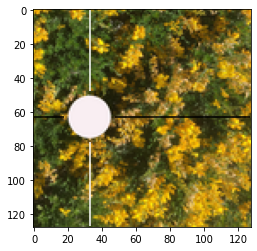

300 of 30000 images...


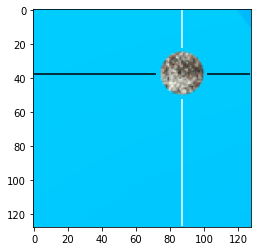

600 of 30000 images...


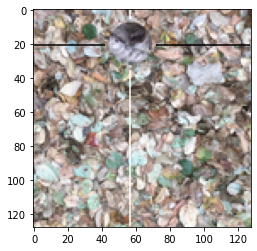

900 of 30000 images...


In [ ]:
# Read FCD training data from a given directory.
reset_random_seeds()
start_time = time.time()
print('Reading', max_input_images, 'images from ' + fcd_ts_dir)

X_train = []  # To release memory when rerunning in notebook?
y_train = []
X_train, y_train = read_fcd_data_from_directory(fcd_ts_dir, max_input_images)

print('Read', X_train.shape[0], 'training images.')
print('Elapsed time:', int(time.time() - start_time), 'seconds.')

# Build and train model

In [ ]:
# Run a model.
reset_random_seeds()
(model, history) = ([], [])  # To release memory when rerunning in notebook?
(model, history) = run_model(make_striding_cnn_model, 'FCD: Striding CNN')

# Analyze results

In [ ]:
# Draw some results to understand performance
# TODO needs to discriminate between training and validation sets.
#      feature best/worse results of both cases?
# 20211210 refactor to not run predict on whole training set
def draw_results(count = 20):
    for i in random.sample(range(X_train.shape[0]), count) :
        pixel_tensor = X_train[i, :, :, :]
        predict = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
        x = predict[0]
        y = predict[1]
        print(i, ": (", x, ",", y, ")")
        draw_image(X_train[i, :, :, :], [x, y])

reset_random_seeds()
draw_results()